In [38]:
import pyvinecopulib as pv
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs

In [39]:
def sample(cop_name, nsamples, params):
    if cop_name == "gaussian":
        corrMatrix = params["corrMatrix"]
        copula = pv.Bicop(family=pv.BicopFamily.gaussian, parameters=corrMatrix)
    elif cop_name == "student":
        corrMatrix = params["corrMatrix"]
        nu = params["nu"]
        copula = pv.Bicop(family=pv.BicopFamily.student, parameters=[corrMatrix, nu])
    elif cop_name == "clayton":
        theta = params["theta"]
        copula = pv.Bicop(family=pv.BicopFamily.clayton, parameters=theta)
    elif cop_name == "gumbel":
        theta = params["theta"]
        copula = pv.Bicop(family=pv.BicopFamily.gumbel, parameters=theta)
    elif cop_name == "mixture":
        combination = params["combination"]
        copulas = [pv.Bicop(family=pv.BicopFamily[comp["type"]], parameters=comp["theta"]) for comp in combination]
        weights = [comp["weight"] for comp in combination]
        copula = pv.MixtureBicop(copulas, weights)
    else:
        raise ValueError(f"Unknown copula type: {cop_name}")
    
    return copula.simulate(nsamples)

def log_likelihood(cop_name, u1, u2, params):
    if cop_name == "gaussian":
        corrMatrix = params["corrMatrix"]
        copula = pv.Bicop(family=pv.BicopFamily.gaussian, parameters=corrMatrix)
    elif cop_name == "student":
        corrMatrix = params["corrMatrix"]
        nu = params["nu"]
        copula = pv.Bicop(family=pv.BicopFamily.student, parameters=[corrMatrix, nu])
    elif cop_name == "clayton":
        theta = params["theta"]
        copula = pv.Bicop(family=pv.BicopFamily.clayton, parameters=theta)
    elif cop_name == "gumbel":
        theta = params["theta"]
        copula = pv.Bicop(family=pv.BicopFamily.gumbel, parameters=theta)
    else:
        raise ValueError(f"Unknown copula type: {cop_name}")
    
    data = np.column_stack((u1, u2))
    return copula.loglik(data)

# Example usage:
params_gaussian = {"corrMatrix": [0.1]}
samples = sample("gaussian", 500, params_gaussian)
u1, u2 = samples[:, 0], samples[:, 1]
log_likelihood_value = log_likelihood("gaussian", u1, u2, params_gaussian)
print(log_likelihood_value)

2.9893544942520864


In [45]:
means

[[(2.425120596675927, 2.7004419055130313)],
 [(-4.202599642031773, -0.7626315117441971)]]

In [48]:
N_TRAIN = 1000
N_TEST = 5000
N_ROUNDS = 25
np.random.seed(990109)

sims_runs_all = []
log_likelihoods_runs_all = []

for round in range(N_ROUNDS):
    # Generate data

    # Student-t
    corrMatrix = np.random.uniform(0.5,0.95)
    nu = np.random.uniform(2,10)

    params_student = {"corrMatrix": corrMatrix, "nu": nu}
    samples_student = sample("student", N_TRAIN + N_TEST, params_student)
    u1_student, u2_student = samples_student[:, 0], samples_student[:, 1]
    log_likelihood_student = log_likelihood("student", u1_student, u2_student, params_student)

    # Clayton
    theta = 2
    params_clayton = {"theta": [theta]}
    samples_clayton = sample("clayton", N_TRAIN + N_TEST, params_clayton)
    u1_clayton, u2_clayton = samples_clayton[:, 0], samples_clayton[:, 1]
    log_likelihood_clayton = log_likelihood("clayton", u1_clayton, u2_clayton, params_clayton)

    # Gumbel
    theta = 2
    params_gumbel = {"theta": [theta]}
    samples_gumbel = sample("gumbel", N_TRAIN + N_TEST, params_gumbel)
    u1_gumbel, u2_gumbel = samples_gumbel[:, 0], samples_gumbel[:, 1]
    log_likelihood_gumbel = log_likelihood("gumbel", u1_gumbel, u2_gumbel, params_gumbel)

    # Mixture of 2 gaussians (using scipy.stats: first mixture on gaussian z-space, then transform to copula u-space)
    means = [[np.random.uniform(-5, 5), np.random.uniform(-5, 5)]for _ in range(2)]
    covs = [np.random.uniform(-0.95, 0.95), np.random.uniform(-0.95, 0.95)]
    multipliers = [np.random.uniform(0.8,1.2), np.random.uniform(0.8,1.2)]
    z = np.concatenate(
        [scs.multivariate_normal.rvs(
        mean=means[i], cov=multipliers[i]*np.array([[1,covs[i]],[covs[i],1]]
        ), size=int(N_TRAIN/2)) for i in range(2)])
    u_1_mix = 0.5*(scs.norm(loc=means[0][0], scale=multipliers[0]).cdf(z[:,0]) + scs.norm(loc=means[1][0], scale=multipliers[1]).cdf(z[:,0]))
    u_2_mix = 0.5*(scs.norm(loc=means[0][1], scale=multipliers[0]).cdf(z[:,1]) + scs.norm(loc=means[1][1], scale=multipliers[1]).cdf(z[:,1]))
    log_likelihood_mix = scs.multivariate_normal.logpdf(z, mean=means[0], cov=multipliers[0]*np.array([[1,covs[0]],[covs[0],1]])).sum() + scs.multivariate_normal.logpdf(z, mean=means[1], cov=multipliers[1]*np.array([[1,covs[1]],[covs[1],1]]).sum())
    
    # append to list
    sims_runs_all.append([[u1_student, u2_student], [u1_clayton, u2_clayton], [u1_gumbel, u2_gumbel],[ u_1_mix, u_2_mix]])
    log_likelihoods_runs_all.append([log_likelihood_student, log_likelihood_clayton, log_likelihood_gumbel, log_likelihood_mix])

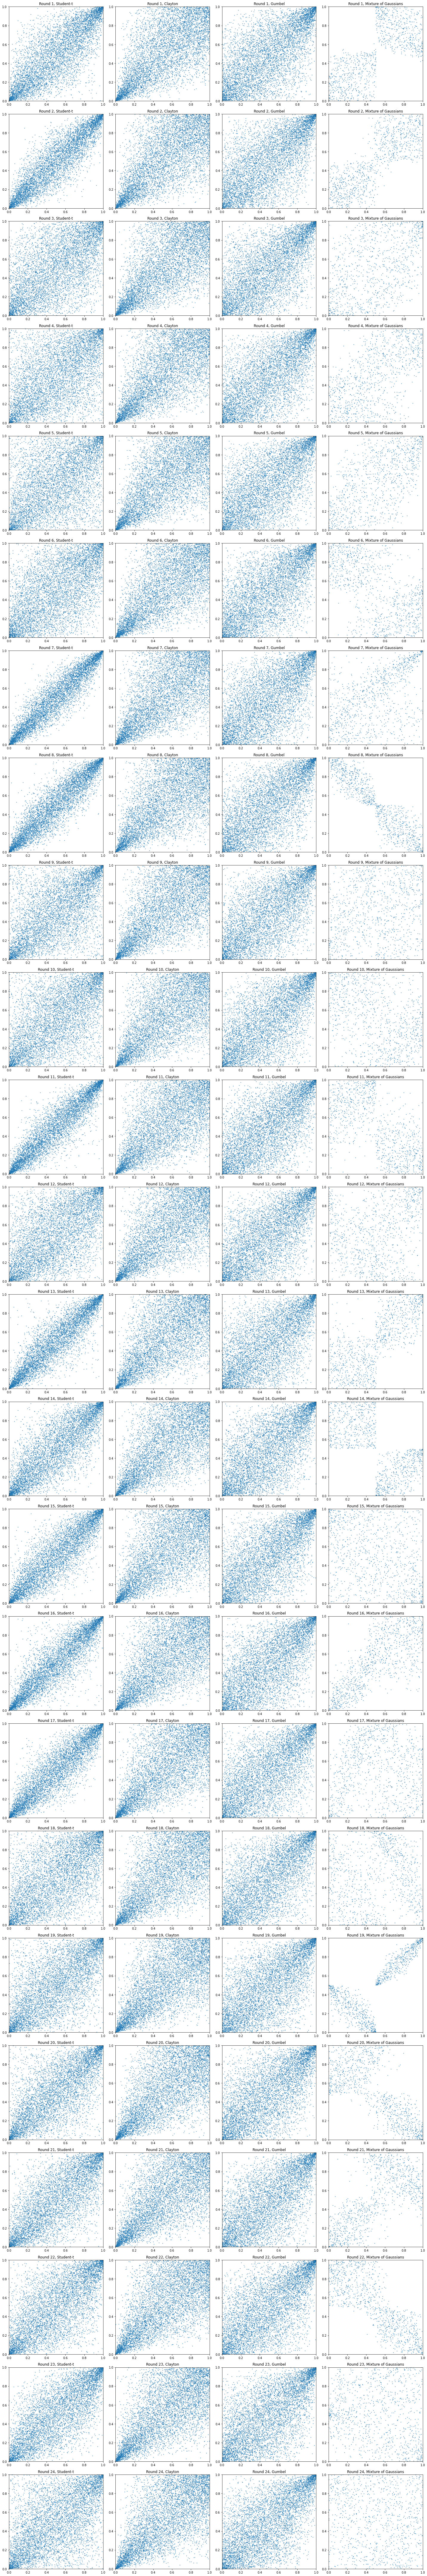

In [50]:
import matplotlib.pyplot as plt

# Assuming sims_runs_all is already populated with the samples

fig, axes = plt.subplots(24, 4, figsize=(20, 120))
axes = axes.flatten()

sample_types = ["Student-t", "Clayton", "Gumbel", "Mixture of Gaussians"]

for i in range(24):
    for j in range(4):
        ax = axes[i * 4 + j]
        u1, u2 = sims_runs_all[i][j]
        ax.scatter(u1, u2, s=1)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_title(f'Round {i+1}, {sample_types[j]}')

plt.tight_layout()
plt.show()

In [1]:


### set options ###
N_TRAIN = 1000
N_TEST = 5000
N_ROUNDS = 25

FAMILIES = ["student", "clayton", "gumbel", "gaussian_mixture"]
L2_SCORES={}

### run experiments ###
LOG={}
for fam in FAMILIES:
    print(fam)
    l2=[]
    logs_fam = {"true": [], "param": [], "param_select": []}
    for i in range(N_ROUNDS):
        cdf_vals={}
        
        if fam != "gaussian_mixture":
        # true copula
            params = random_bicop(fam)
            logs_fam["true"].append(params)
            params["family"] = get_pvcopfamily(fam)
            copula = pv.Bicop(**params)
            u_train = copula.simulate(N_TRAIN)
            U_TEST = copula.simulate(N_TEST)
            cdf_vals_true = np.reshape(copula.cdf(U_TEST), (-1,1))

        else:
            u_train, U_TEST, cdf_vals_true, params = gaussian_mixture_copula(n_train=N_TRAIN, n_test=N_TEST, n_sim=200000)
            cdf_vals_true = np.reshape(cdf_vals_true, (-1,1))
            logs_fam["true"].append(params)

        # # fit IGC copula
        cop_igc = ImplicitGenerativeCopula(dim_latent=6, dim_out=2, n_samples_train=200, n_layers=2, n_neurons=100)           
        hist=cop_igc.fit(u_train, batch_size=100, epochs=500)
        cdf_vals["igc"] = cop_igc.cdf(v=U_TEST, n=200000)
        
        errors = cdf_vals_true-pd.DataFrame(cdf_vals)
        l2.append(errors.pow(2).sum(axis=0))
    
    L2_SCORES[fam] = pd.DataFrame(l2)
    LOG[fam] = logs_fam


# train ratio copula
ratios = []


    # Ratio copula
    for i in tqdm(range(len(data_u1_u2))):
        u1, u2 = data_u1_u2[i]
        z1, z2 = scipy.stats.norm.ppf(u1), scipy.stats.norm.ppf(u2)
        p_data = np.column_stack((z1, z2))
        p_data = np.nan_to_num(p_data, nan=0, posinf=0, neginf=0)
        q_data = np.random.randn(50000,2)
        ratio = Ratio(h_dim=100, in_dim=2, h_layers=2)

        optimizer = torch.optim.Adam(ratio.parameters(), lr= 0.002)

            
        for epoch in (range(200)):
            optimizer.zero_grad()
            r_p = ratio(tt(p_data).float())
            r_q = ratio(tt(np.random.randn(1000,2)).float())
            #loss = (-(r_p /(1+r_p)).log() - (1/(1+r_q)).log() ).mean()
            loss = loss_nce(r_p, r_q, p_data.shape[0], q_data.shape[0])
            loss.backward()
            optimizer.step()
            if epoch % 100 == 0:
                with torch.no_grad():
                    print(f'Epoch {epoch}, loss {loss.item()}')

        ratios.append(ratio)


for fam,scores in L2_SCORES.items():
    fix,ax = plt.subplots()
    ax = sns.boxplot(data=scores)
    ax.set_title(f"L2 score for {fam}")
    #scores.to_csv("results/bivariate_L2_"+fam+".csv")

# def save_obj(obj, name ):
#     with open('logs/'+ name + '.pkl', 'wb') as f:
#         pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

# dt_string = datetime.now().strftime("%Y%m%d%H%M%S")
# for fam, log in LOG.items():
#     save_obj(log, "logs_"+fam+"_"+dt_string)

ModuleNotFoundError: No module named 'experiments_utils'